In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import xgboost as xgb

In [2]:
## Plot function to look at confusion matrix
def plot_cfm(y_test,vals):
    num = confusion_matrix(y_test, vals)
    num = num/np.sum(num,axis=1)
    plt.figure(figsize=[7,6])
    ax = plt.subplot()
    sns.heatmap(num, annot=True, ax = ax, )

    ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
    ax.xaxis.set_ticklabels(['neg', 'pos']); ax.yaxis.set_ticklabels(['neg', 'pos'])
    plt.show()
    pass

In [3]:
## Import data and grab only needed columns
train = pd.read_csv('clean_tweet.csv')
test = pd.read_csv('clean_test.csv')
train = train[['text','target']]
test = test[['text','target']]

In [5]:
train.shape

(1600000, 2)

## XG Boost

In [30]:
## Create XGBoost pipeline to compute accuracy
xg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', xgb.XGBClassifier(n_estimators=1000, max_depth=5, objective='binary:logistic',
            learning_rate=0.1)),
])
xg.fit(train['text'].apply(lambda x: np.str_(x)), train['target'])
xg_vals = xg.predict(test['text'].apply(lambda x: np.str_(x)))

In [31]:
## Show classification results from XGBoost
print(classification_report(test['target'], xg_vals))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73       188
           4       0.75      0.85      0.80       217

   micro avg       0.77      0.77      0.77       405
   macro avg       0.77      0.76      0.76       405
weighted avg       0.77      0.77      0.77       405



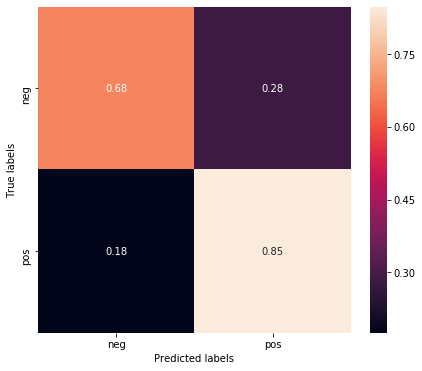

In [32]:
## Show confusion matrix for each label on XGBoost
plot_cfm(test['target'], xg_vals)

## Logistic Regression Results

In [24]:
## Create Logistic Regression pipeline to compute accuracy
lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(penalty='l2',tol=1e-5,max_iter=4000,solver='lbfgs')),
])
lr.fit(train['text'].apply(lambda x: np.str_(x)), train['target'])
lr_vals = lr.predict(test['text'].apply(lambda x: np.str_(x)))

In [25]:
## Show classification results from Logistic Regression
print(classification_report(test['target'], lr_vals))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       188
           4       0.80      0.84      0.82       217

   micro avg       0.80      0.80      0.80       405
   macro avg       0.81      0.80      0.80       405
weighted avg       0.81      0.80      0.80       405



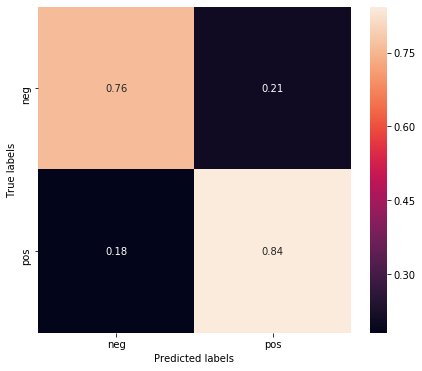

In [26]:
## Show confusion matrix for each label on Logistic regression
plot_cfm(test['target'], lr_vals)

## Multinomial Naive Bayes Results

In [27]:
## Create Multinomial Naive Bayes pipeline to compute accuracy
mnb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1,fit_prior=True)),
])
mnb.fit(train['text'].apply(lambda x: np.str_(x)), train['target'])
mnb_vals = mnb.predict(test['text'].apply(lambda x: np.str_(x)))

In [28]:
## Show classification results from Multinomial Naive Bayes
print(classification_report(test['target'], mnb_vals))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       188
           4       0.80      0.78      0.79       217

   micro avg       0.78      0.78      0.78       405
   macro avg       0.78      0.78      0.78       405
weighted avg       0.78      0.78      0.78       405



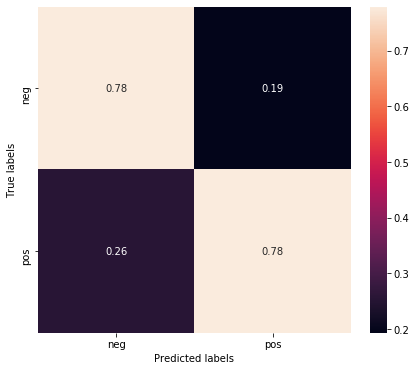

In [29]:
## Show confusion matrix for each label on Multinomial Naive Bayes
plot_cfm(test['target'], mnb_vals)

Noticing our problem only looks at binary classification, attempted to use Gaussian Naive Bayes model but it unfortunately crashed my computer due to its size. Need to come back and try using GPU for this problem.

In [57]:
## Transform train and test data in preparation for Gaussian Naive Bayes model
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['text'].apply(lambda x: np.str_(x)))
X_test_counts = count_vect.transform(test['text'].apply(lambda x: np.str_(x)))
print(X_train_counts.shape)
print(X_test_counts.shape)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)
print(X_train_tf.shape)
print(X_test_tf.shape)

(1600000, 273694)
(405, 273694)
(1600000, 273694)
(405, 273694)


In [ ]:
## Train and predict twitter data using Guassian Naive Bayes
nb = GaussianNB()
nb.fit(X_train_tf.toarray(), train['target'])
nb_vals = nb.predict(X_test_tf.toarray())

In [ ]:
## Show classification report for data
print(classification_report(test['target'], nb_vals))

In [ ]:
## Plot confusion matrix
plot_cfm(test['target'], nb_vals)

## RandomForest Results

In [33]:
## Create Random Forest pipeline to compute accuracy, show accuracy metrics and confusion matrix
rf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=1000,max_depth=10,min_samples_leaf=5)),
])
rf.fit(train['text'].apply(lambda x: np.str_(x)), train.target)
rf_vals = rf.predict(test['text'].apply(lambda x: np.str_(x)))

In [34]:
print(classification_report(test['target'], rf_vals))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       188
           4       0.76      0.83      0.79       217

   micro avg       0.77      0.77      0.77       405
   macro avg       0.77      0.76      0.76       405
weighted avg       0.77      0.77      0.77       405



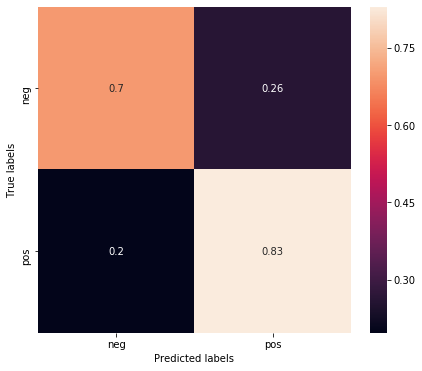

In [35]:
plot_cfm(test['target'], rf_vals)

## Stochastic Gradient Descent

In [36]:
## Create Stochastic Gradient Descent pipeline to compute accuracy, show accuracy metrics and confusion matrix
sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(penalty='elasticnet',random_state=42,alpha=1e-5,max_iter=4000,tol=1e-5)),
])
sgd.fit(train['text'].apply(lambda x: np.str_(x)), train.target)
sgd_vals = sgd.predict(test['text'].apply(lambda x: np.str_(x)))

In [37]:
print(classification_report(test['target'], sgd_vals))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       188
           4       0.78      0.84      0.81       217

   micro avg       0.79      0.79      0.79       405
   macro avg       0.79      0.79      0.79       405
weighted avg       0.79      0.79      0.79       405



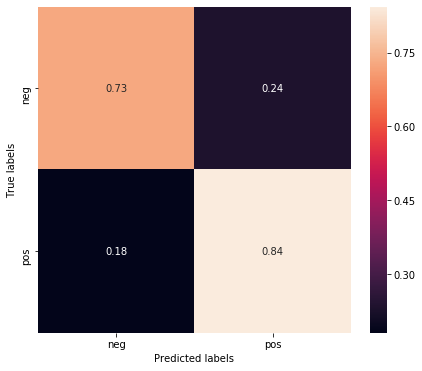

In [38]:
plot_cfm(test['target'], sgd_vals)

## Various other cleaning data used for trial and error

In [ ]:
search.best_params_

In [ ]:
new_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42)), # CHANGE NEW PARAMS
])

In [ ]:
vals = search.predict(test['text'].apply(lambda x: np.str_(x)))
np.mean(vals == test.target)

In [32]:
text_clf.fit(train['text'].apply(lambda x: np.str_(x)), train.target)
vals = text_clf.predict(test['text'].apply(lambda x: np.str_(x)))
np.mean(vals == test.target)

0.7185185185185186

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df['text'].apply(lambda x: np.str_(x)))
print(X_train_counts.shape)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
print(X_train_tf.shape)

In [ ]:
pc = TruncatedSVD(n_components=5000)
pc.fit(X_train_tf)
print(np.sum(pc.explained_variance_ratio_))

In [17]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df['text'].apply(lambda x: np.str_(x)))
X_train_counts.shape
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(1600000, 273694)

In [19]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(1600000, 273694)

In [20]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, df['target'])

In [17]:
new_train = train[720000:880000]

In [18]:
new_train.shape

(160000, 2)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(new_train['text'].apply(lambda x: np.str_(x)),new_train['target'],test_size=0.01,random_state=42)


In [20]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    #('pca', pca.PCA(n_components=5000)),
    ('clf', xgb.XGBClassifier(n_estimators=1000, max_depth=5, objective='binary:logistic',
            learning_rate=0.1)),
])
text_clf.fit(X_train, y_train)
vals = text_clf.predict(X_test)

In [21]:
print(classification_report(y_test, vals))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       797
           4       0.77      0.82      0.79       803

   micro avg       0.78      0.78      0.78      1600
   macro avg       0.78      0.78      0.78      1600
weighted avg       0.78      0.78      0.78      1600



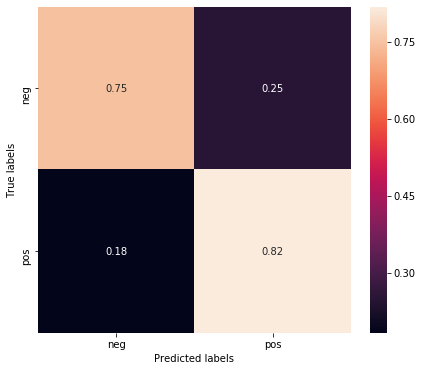

In [22]:
plot_cfm(y_test, vals)

In [55]:
pipe.fit(train['text'].apply(lambda x: np.str_(x)), train.target)
vals = pipe.predict(test['text'].apply(lambda x: np.str_(x)))
np.mean(vals == test.target)

0.7901234567901234

In [42]:
params = {'clf__alpha': [1e-5,1e-4,1e-3],
          'clf__max_iter':[3000,4000,5000],
          'clf__tol':[1e-5,1e-4,1e-3],
}

In [43]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(pipe, params, n_jobs=-1,cv=3,verbose=2)
search.fit(train['text'].apply(lambda x: np.str_(x)), train.target)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
### Neural Net Paper: walk through each of these
https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
https://towardsdatascience.com/sentiment-analysis-with-deep-learning-62d4d0166ef6
https://machinelearningmastery.com/crash-course-deep-learning-natural-language-processing/ - DO THIS ONE